# REU Poster Figures

In [1]:
import xarray as xr
import matplotlib.pyplot as plt
import numpy as np
import argopy
import scipy.ndimage as filter
filter.gaussian_filter1d
import cartopy.crs as ccrs
import cartopy

## Useful Functions

In [47]:
def get_ds_interp(ds,depth_min,depth_max,sample_max):
    median_dp=ds.PRES.where(ds.PRES<depth_max).where(ds.PRES>depth_min).diff('N_LEVELS').median('N_LEVELS')
    ind_rate=median_dp.where(median_dp<sample_max,drop=True).N_PROF
    ds_sel=ds.sel(N_PROF=ind_rate)
    ds_interp=ds_sel.argo.interp_std_levels(np.arange(depth_min,depth_max,2)) #is this where we lose other variables?
    ds_interp=ds_interp.sortby(ds_interp.N_PROF)
    
    number=np.arange(0,len(ds_interp.N_PROF))
    ds_interp['N_PROF_NEW']=xr.DataArray(number,dims=ds_interp.N_PROF.dims)
    return ds_interp

In [48]:
def get_ds_filt(ds_interp,first,last,num,variable='TEMP'):
    sigmas=np.logspace(first,last,num)
    temp=np.zeros((ds_interp.N_PROF.shape[0],ds_interp.PRES_INTERPOLATED.shape[0],num))

    for n in range(0,num):
        temp[:,:,n]=filter.gaussian_filter1d(ds_interp[variable],sigma=sigmas[n],mode='nearest')

    ds_filt=xr.DataArray(temp,dims=['N_PROF','PRES_INTERPOLATED','FILT_SCALE'],
             coords={'N_PROF':ds_interp.N_PROF,'PRES_INTERPOLATED':ds_interp.PRES_INTERPOLATED,'FILT_SCALE':sigmas})
    
    number=np.arange(0,len(ds_filt.N_PROF))
    ds_filt['N_PROF_NEW']=xr.DataArray(number,dims=ds_filt.N_PROF.dims)
    return ds_filt

In [49]:
def get_var(ds_interp,ds_filt,variable='TEMP'):
    var=np.zeros(len(ds_filt.FILT_SCALE))
    for n,sig in enumerate(so_filt.FILT_SCALE):
        prof=ds_filt.sel(FILT_SCALE=sig)
        var[n]=(prof-ds_interp[variable]).var()
    return var

In [50]:
def get_2_depths(ds,first,mid,last,sample_max,variable='TEMP'):
    interp_1=get_ds_interp(ds,first,mid,sample_max)
    interp_2=get_ds_interp(ds,mid,last,sample_max)
    
    filt_1=get_ds_filt(interp_1,0.5,2.5,50)
    filt_2=get_ds_filt(interp_2,0.5,2.5,50)
    
    var_1=get_var(interp_1,filt_1)
    var_2=get_var(interp_2,filt_2)
    
    return filt_1,var_1,filt_2,var_2

In [51]:
def get_3_depths(ds,first,mid1,mid2,last,sample_max,variable='TEMP'):
    interp_1=get_ds_interp(ds,first,mid1,sample_max)
    interp_2=get_ds_interp(ds,mid1,mid2,sample_max)
    interp_3=get_ds_interp(ds,mid2,last,sample_max)
    
    filt_1=get_ds_filt(interp_1,0.5,2.5,50)
    filt_2=get_ds_filt(interp_2,0.5,2.5,50)
    filt_3=get_ds_filt(interp_3,0.5,2.5,50)
    
    var_1=get_var(interp_1,filt_1)
    var_2=get_var(interp_2,filt_2)
    var_3=get_var(interp_3,filt_3)
    
    return filt_1,var_1,filt_2,var_2,filt_3,var_3

## Housekeeping

In [52]:
np_param=[-155,-145,30,35,0,2000]
np_ds=xr.open_dataset("202206_lon:(-155,-145)_lat:(30,35).nc")
na_param=[-55,-45,40,45,0,2000]
na_ds=xr.open_dataset("202206_lon:(-55,-45)_lat:(40,45).nc")
so_param=[30,40,-55,-50,0,2000]
so_ds=xr.open_dataset("202206_lon:(30,40)_lat:(-55,-50).nc")
io_param=[90,100,-15,-10,0,2000]
io_ds=xr.open_dataset("202206_lon:(90,100)_lat:(-15,-10).nc")

In [53]:
so_interp=get_ds_interp(so_ds,0,2000,3)
np_interp=get_ds_interp(np_ds,0,2000,3)
na_interp=get_ds_interp(na_ds,0,2000,3)
io_interp=get_ds_interp(io_ds,0,2000,3)

In [54]:
so_filt=get_ds_filt(so_interp,0.5,2.5,50)
np_filt=get_ds_filt(np_interp,0.5,2.5,50)
na_filt=get_ds_filt(na_interp,0.5,2.5,50)
io_filt=get_ds_filt(io_interp,0.5,2.5,50)

In [55]:
so_var=get_var(so_interp,so_filt)
np_var=get_var(np_interp,np_filt)
na_var=get_var(na_interp,na_filt)
io_var=get_var(io_interp,io_filt)

## Methods

#### Filtering Example

## Data

#### Map of Boxes

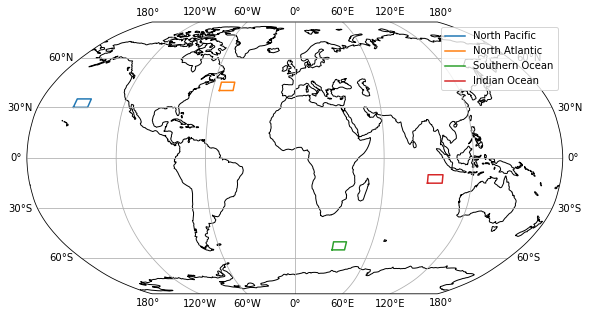

In [58]:
plt.figure(figsize=(12,5))
ax=plt.axes(projection=ccrs.Robinson())
ax.set_global()
ax.coastlines()
ax.gridlines(draw_labels=True)
plt.plot((np_param[0],np_param[1],np_param[1],np_param[0],np_param[0]), (np_param[2],np_param[2],np_param[3],np_param[3],np_param[2]),transform=ccrs.PlateCarree(),label='North Pacific')
plt.plot((na_param[0],na_param[1],na_param[1],na_param[0],na_param[0]), (na_param[2],na_param[2],na_param[3],na_param[3],na_param[2]),transform=ccrs.PlateCarree(),label='North Atlantic')
plt.plot((so_param[0],so_param[1],so_param[1],so_param[0],so_param[0]), (so_param[2],so_param[2],so_param[3],so_param[3],so_param[2]),transform=ccrs.PlateCarree(),label='Southern Ocean')
plt.plot((io_param[0],io_param[1],io_param[1],io_param[0],io_param[0]), (io_param[2],io_param[2],io_param[3],io_param[3],io_param[2]),transform=ccrs.PlateCarree(),label='Indian Ocean')
plt.legend()

#### All Boxes Results

Text(0.5, 1.0, 'Variance plot over (0m, 2000m) for all four regions')

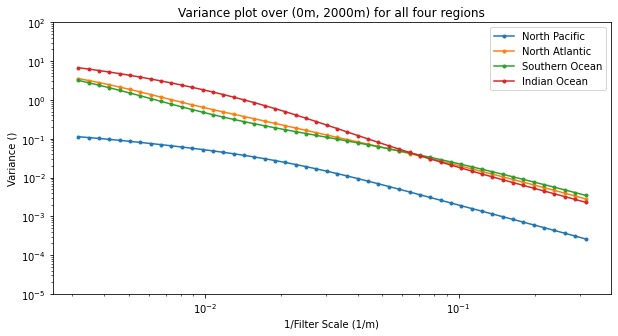

In [59]:
plt.figure(figsize=(10,5))
xs=[1/so_filt.FILT_SCALE,1/np_filt.FILT_SCALE,1/na_filt.FILT_SCALE,1/io_filt.FILT_SCALE]
ys=[so_var,np_var,na_var,io_var]
titles=['North Pacific','North Atlantic','Southern Ocean','Indian Ocean']

for n in range(0,4):
    plt.plot(xs[n],ys[n],'.-',label=titles[n])
    plt.xscale('log')
    plt.yscale('log')
    plt.xlabel("1/Filter Scale (1/m)")
    plt.ylabel("Variance ()")
    plt.ylim(10**-5,10**2)
    
plt.subplots_adjust(hspace=0.4,wspace=0.4)
plt.legend()
plt.title("Variance plot over (0m, 2000m) for all four regions")

#### Anomaly Plots

ValueError: x must be one of None, 'LATITUDE', 'LONGITUDE', 'N_PROF', 'PRES_INTERPOLATED', 'TIME'

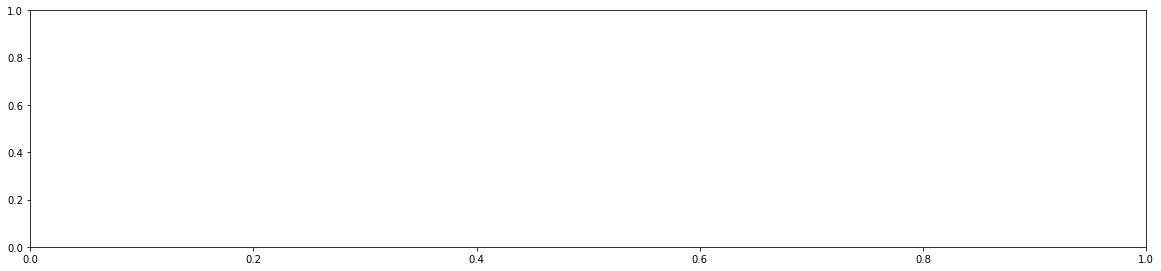

In [67]:
plt.figure(figsize=(20,20))
interps=[np_interp,na_interp,so_interp,io_interp]
filts=[np_filt,na_filt,so_filt,io_filt]
titles=['North Pacific','North Atlantic','Southern Ocean','Indian Ocean']

for n in range(0,4):
    plt.subplot(4,1,n+1)
    interp=interps[n].TEMP
    filt=filts[n]
    anom=interp-interp.mean()
    anom.plot(x='N_PROF_NEW',y='PRES_INTERPOLATED',robust=True)
    plt.gca().invert_yaxis()
    plt.title(titles[n])
    
plt.subplots_adjust(hspace=0.4)